# Imoprt important libraries

In [1]:
import pandas as pd
import numpy as np
import string, os,re,pickle
import warnings
warnings.filterwarnings("ignore")
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense,Dropout
from keras.preprocessing.text import Tokenizer
import keras.utils as ku 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import io
import cufflinks as cf
cf.go_offline()

%matplotlib inline

In [2]:
df1 = pd.read_csv('ted_main.csv')
transcripts = pd.read_csv('transcripts.csv')

In [3]:
df1.head()

,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,ratings,related_talks,speaker_occupation,tags,title,url,views
0,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,1140825600,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...","[{'id': 865, 'hero': 'https://pe.tedcdn.com/im...",Author/educator,"['children', 'creativity', 'culture', 'dance',...",Do schools kill creativity?,https://www.ted.com/talks/ken_robinson_says_sc...,47227110
1,265,With the same humor and humanity he exuded in ...,977,TED2006,1140825600,43,Al Gore,Al Gore: Averting the climate crisis,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 544}, {'i...","[{'id': 243, 'hero': 'https://pe.tedcdn.com/im...",Climate advocate,"['alternative energy', 'cars', 'climate change...",Averting the climate crisis,https://www.ted.com/talks/al_gore_on_averting_...,3200520
2,124,New York Times columnist David Pogue takes aim...,1286,TED2006,1140739200,26,David Pogue,David Pogue: Simplicity sells,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 964}, {'i...","[{'id': 1725, 'hero': 'https://pe.tedcdn.com/i...",Technology columnist,"['computers', 'entertainment', 'interface desi...",Simplicity sells,https://www.ted.com/talks/david_pogue_says_sim...,1636292
3,200,"In an emotionally charged talk, MacArthur-winn...",1116,TED2006,1140912000,35,Majora Carter,Majora Carter: Greening the ghetto,1,1151367060,"[{'id': 3, 'name': 'Courageous', 'count': 760}...","[{'id': 1041, 'hero': 'https://pe.tedcdn.com/i...",Activist for environmental justice,"['MacArthur grant', 'activism', 'business', 'c...",Greening the ghetto,https://www.ted.com/talks/majora_carter_s_tale...,1697550
4,593,You've never seen data presented like this. Wi...,1190,TED2006,1140566400,48,Hans Rosling,Hans Rosling: The best stats you've ever seen,1,1151440680,"[{'id': 9, 'name': 'Ingenious', 'count': 3202}...","[{'id': 2056, 'hero': 'https://pe.tedcdn.com/i...",Global health expert; data visionary,"['Africa', 'Asia', 'Google', 'demo', 'economic...",The best stats you've ever seen,https://www.ted.com/talks/hans_rosling_shows_t...,12005869


In [4]:
transcripts.head()

,transcript,url
0,Good morning. How are you?(Laughter)It's been ...,https://www.ted.com/talks/ken_robinson_says_sc...
1,"Thank you so much, Chris. And it's truly a gre...",https://www.ted.com/talks/al_gore_on_averting_...
2,"(Music: ""The Sound of Silence,"" Simon & Garfun...",https://www.ted.com/talks/david_pogue_says_sim...
3,If you're here today — and I'm very happy that...,https://www.ted.com/talks/majora_carter_s_tale...
4,"About 10 years ago, I took on the task to teac...",https://www.ted.com/talks/hans_rosling_shows_t...


In [5]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2550 entries, 0 to 2549
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   comments            2550 non-null   int64 
 1   description         2550 non-null   object
 2   duration            2550 non-null   int64 
 3   event               2550 non-null   object
 4   film_date           2550 non-null   int64 
 5   languages           2550 non-null   int64 
 6   main_speaker        2550 non-null   object
 7   name                2550 non-null   object
 8   num_speaker         2550 non-null   int64 
 9   published_date      2550 non-null   int64 
 10  ratings             2550 non-null   object
 11  related_talks       2550 non-null   object
 12  speaker_occupation  2544 non-null   object
 13  tags                2550 non-null   object
 14  title               2550 non-null   object
 15  url                 2550 non-null   object
 16  views               2550

In [6]:
df1.isnull().sum()

comments              0
description           0
duration              0
event                 0
film_date             0
languages             0
main_speaker          0
name                  0
num_speaker           0
published_date        0
ratings               0
related_talks         0
speaker_occupation    6
tags                  0
title                 0
url                   0
views                 0
dtype: int64

### missing null values
as there are only 6 null values in the occupation column we can fill it with the mode value of the column to keep the 2550 numbers even

In [7]:
df1['speaker_occupation'] = df1.speaker_occupation.fillna(df1.speaker_occupation.mode()[0])

# **EXPLORATORY DATA ANALYSIS**

In [8]:
#converting to datetime object
df1['film_date'] = pd.to_datetime(df1['film_date'], unit='s')
df1['published_date'] = pd.to_datetime(df1['published_date'], unit='s')

#creating a year column
df1['year'] = df1['film_date'].apply(lambda x: x.year)

#converting duration unit to minute
df1['duration'] = df1['duration'].apply(lambda x: round(x/60, 2))

### ▶ Number of TED talks throughout the years

<AxesSubplot:>

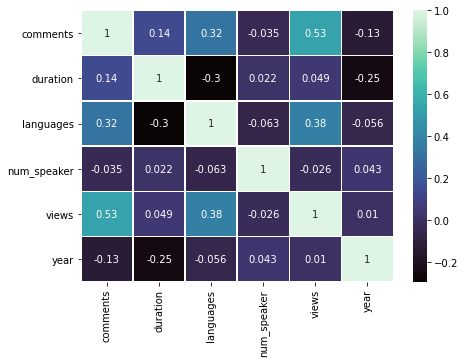

In [9]:
fig, ax = plt.subplots(figsize=(7, 5))    
sns.heatmap(df1.corr(), annot = True, linewidths =.5, ax = ax, cmap = 'mako')

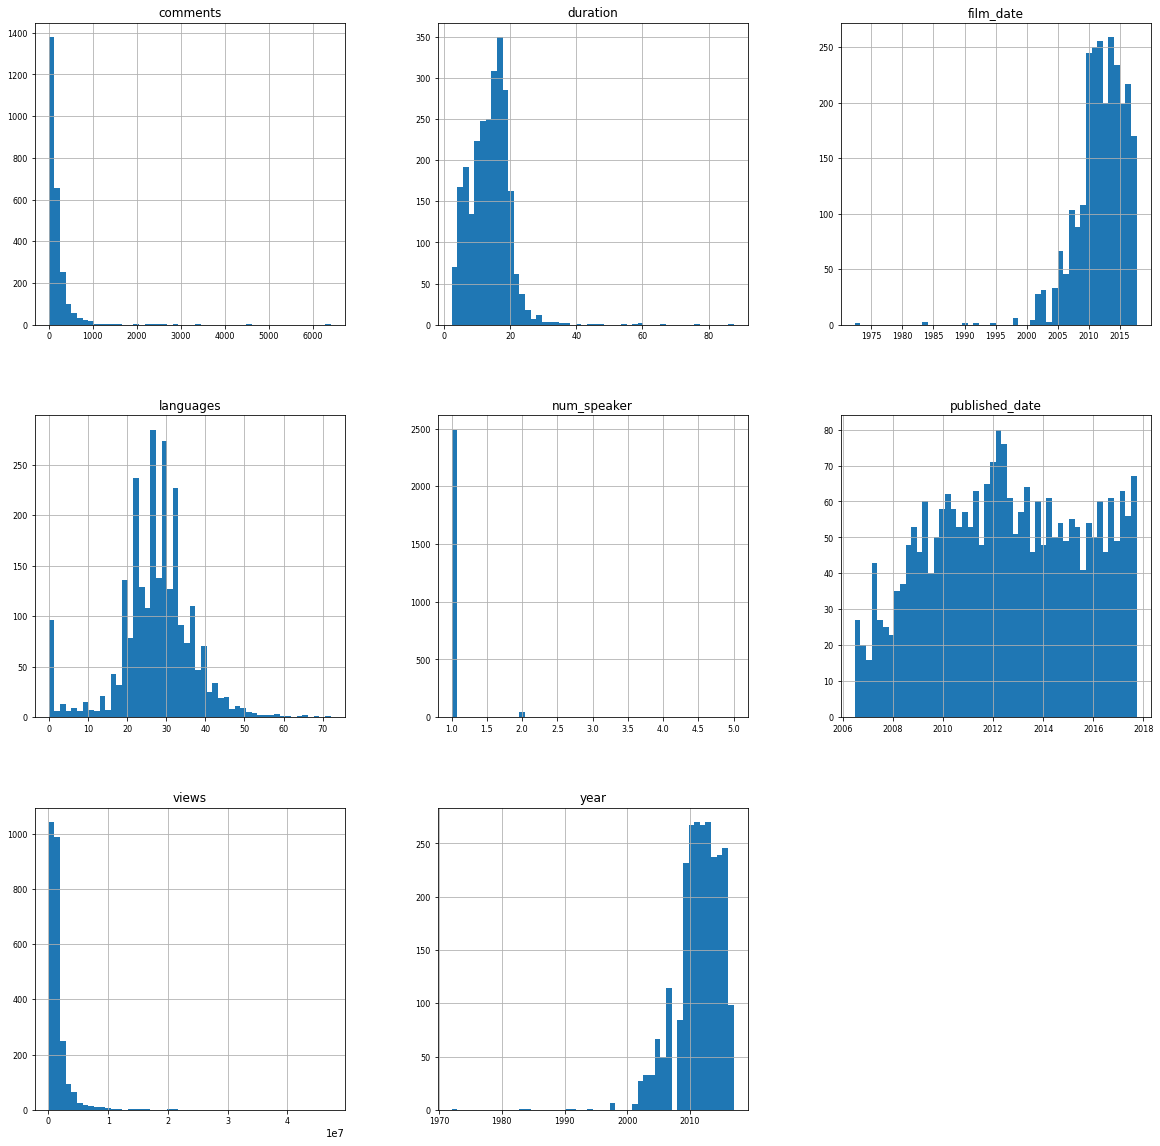

In [10]:
df1.hist(figsize=(20, 20), bins=50, xlabelsize=8, ylabelsize=8); 

### ▶ Checking the distribution of view, comments, and duration

In [11]:
views = df1.sort_values(by = 'views', ascending = False).head(10).reset_index()


fig = px.bar_polar(views, 
                   r="duration", 
                   theta="title", 
                   color="views",
                   color_discrete_sequence= px.colors.sequential.Plasma_r,
                   title="top 10 talks, number of views and duration"
                  )
fig.show()

### ▶ top 10 TED events held

In [12]:
events = pd.DataFrame(df1['event'].value_counts().head(20)).reset_index()


fig = px.bar(events, 
             x ='index', 
             y='event',
             color = 'index',
             color_continuous_scale = px.colors.sequential.Oryel, 
             title=' Number of TED talks throughout the years',
             labels=dict(x= "year", y="number of talks", color = 'year'))
fig.show()

### ▶ relation between views and comments of talks

In [13]:
fig = px.scatter(df1, 
                 x = "comments", 
                 y = "views", 
                 size = "comments", 
                 color = "views",
                 hover_name="title", 
                 log_x=True, 
                 size_max=60)
fig.show()

### ▶ what are the most repeated occupations of speakers

In [14]:
speakers = pd.DataFrame(df1['speaker_occupation'].value_counts().head(10)).reset_index()

fig = px.pie(speakers, 
             values='speaker_occupation', 
             names='index', 
             title='the most repeated occupations of speakers')
fig.show()
print("we can see that writers represent the greatest portion of speaker's occupations")

we can see that writers represent the greatest portion of speaker's occupations


### ▶ Longest 10 talks

In [15]:
duration = df1.sort_values(by = 'duration', ascending = False).head(10)

fig = px.bar(duration, 
             x ='title', 
             y='duration',
             color = 'views',
             color_continuous_scale = px.colors.sequential.Oryel, 
             title='longest 10 talks')
fig.show()

### ▶ Number of TED talks throughout the years

In [16]:
years = pd.DataFrame(df1['year'].value_counts()).reset_index()

fig = px.bar(years, 
             x ='index', 
             y='year',
             color = 'year',
             color_continuous_scale = px.colors.sequential.Oryel, 
             title=' Number of TED talks throughout the years',
             labels=dict(x= "year", y="number of talks", color = 'number'))
fig.show()

### ▶ Number of words in each talk

In [17]:
transcripts['number_of_words']= transcripts['transcript'].str.split().str.len()

fig = px.histogram(transcripts, x="number_of_words", hover_data=transcripts.columns)
fig.show()

## Text Generation Model

In [18]:
transcripts.head()

,transcript,url,number_of_words
0,Good morning. How are you?(Laughter)It's been ...,https://www.ted.com/talks/ken_robinson_says_sc...,3066
1,"Thank you so much, Chris. And it's truly a gre...",https://www.ted.com/talks/al_gore_on_averting_...,2089
2,"(Music: ""The Sound of Silence,"" Simon & Garfun...",https://www.ted.com/talks/david_pogue_says_sim...,3253
3,If you're here today — and I'm very happy that...,https://www.ted.com/talks/majora_carter_s_tale...,3015
4,"About 10 years ago, I took on the task to teac...",https://www.ted.com/talks/hans_rosling_shows_t...,3121


In [19]:
transcripts.shape

(2467, 3)

In [20]:
c=0
for i in transcripts["transcript"]:
    c=c+len(i)
print ("Total Words in Data:",c)

Total Words in Data: 28218860


In [21]:
transcripts["transcript"][0]

'Good morning. How are you?(Laughter)It\'s been great, hasn\'t it? I\'ve been blown away by the whole thing. In fact, I\'m leaving.(Laughter)There have been three themes running through the conference which are relevant to what I want to talk about. One is the extraordinary evidence of human creativity in all of the presentations that we\'ve had and in all of the people here. Just the variety of it and the range of it. The second is that it\'s put us in a place where we have no idea what\'s going to happen, in terms of the future. No idea how this may play out.I have an interest in education. Actually, what I find is everybody has an interest in education. Don\'t you? I find this very interesting. If you\'re at a dinner party, and you say you work in education — Actually, you\'re not often at dinner parties, frankly.(Laughter)If you work in education, you\'re not asked.(Laughter)And you\'re never asked back, curiously. That\'s strange to me. But if you are, and you say to somebody, you

## convert data to text

In [22]:
text=""
for i in transcripts["transcript"]:
    text+=i

In [23]:
text[-100:]

'might be that this is not just a game. It might be a way to decide our own fate.Thank you.(Applause)'

In [24]:
len(text)

28218860

As the data is huge..
We selected slice of text to train the model

In [25]:
train_text=text[:100000]

In [26]:
len(train_text)

100000

## text Cleaning

In [27]:
cleaned_text=[]
txt=re.sub("([\(\[]).*?([\)\]])", "\g<1>\g<2>", train_text)
txt=txt.strip().replace("\'","'")
for i in txt:
    if i not in string.punctuation.replace("'",""):
        cleaned_text.append(i)
    else:
        cleaned_text.append(" ")
cleaned_text="".join(cleaned_text).lower()

In [28]:
cleaned_text[:100]

"good morning  how are you   it's been great  hasn't it  i've been blown away by the whole thing  in "

## tokenizer

In [29]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts([cleaned_text])

# saving the tokenizer for predict function
#pickle.dump(tokenizer, open('/content/drive/MyDrive/ted talks/token.pkl', 'wb'))

sequence_data = tokenizer.texts_to_sequences([cleaned_text])[0]
sequence_data[:15]

[120, 672, 49, 17, 6, 24, 104, 325, 894, 11, 105, 104, 895, 366, 56]

In [30]:
tokenizer.index_word

{1: 'the',
 2: 'and',
 3: 'to',
 4: 'of',
 5: 'a',
 6: 'you',
 7: 'i',
 8: 'in',
 9: 'is',
 10: 'that',
 11: 'it',
 12: 'we',
 13: 'this',
 14: 'have',
 15: 'was',
 16: 'but',
 17: 'are',
 18: 'what',
 19: 'they',
 20: '—',
 21: 'on',
 22: 'for',
 23: 'not',
 24: "it's",
 25: 'so',
 26: 'all',
 27: 'if',
 28: 'there',
 29: 'do',
 30: 'like',
 31: 'be',
 32: 'with',
 33: 'can',
 34: 'here',
 35: 'people',
 36: 'about',
 37: 'my',
 38: 'your',
 39: 'one',
 40: 'get',
 41: 'at',
 42: 'know',
 43: 'world',
 44: 'from',
 45: 'because',
 46: "i'm",
 47: 'now',
 48: 'or',
 49: 'how',
 50: 'out',
 51: 'more',
 52: 'me',
 53: 'as',
 54: "don't",
 55: 'think',
 56: 'by',
 57: 'he',
 58: 'had',
 59: 'when',
 60: 'up',
 61: 'which',
 62: 'just',
 63: 'them',
 64: 'said',
 65: 'our',
 66: 'got',
 67: 'some',
 68: 'life',
 69: 'these',
 70: 'an',
 71: 'very',
 72: 'their',
 73: 'she',
 74: 'did',
 75: 'were',
 76: 'who',
 77: 'way',
 78: 'new',
 79: 'will',
 80: 'where',
 81: 'going',
 82: 'put',
 8

In [31]:
len(sequence_data)

17931

In [32]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

3061


# Make sequences

In [33]:
sequences = []

for i in range(3, len(sequence_data)):
    words = sequence_data[i-3:i+1]
    sequences.append(words)
    
print("The Length of sequences are: ", len(sequences))
sequences = np.array(sequences)
sequences[:10]

The Length of sequences are:  17928


array([[120, 672,  49,  17],
       [672,  49,  17,   6],
       [ 49,  17,   6,  24],
       [ 17,   6,  24, 104],
       [  6,  24, 104, 325],
       [ 24, 104, 325, 894],
       [104, 325, 894,  11],
       [325, 894,  11, 105],
       [894,  11, 105, 104],
       [ 11, 105, 104, 895]])

# split sequences 

In [34]:
X = []
y = []

for i in sequences:
    X.append(i[0:3])
    y.append(i[3])
    
X = np.array(X)
y = np.array(y)

In [35]:
print("Data: ", X[:10])
print("Response: ", y[:10])

Data:  [[120 672  49]
 [672  49  17]
 [ 49  17   6]
 [ 17   6  24]
 [  6  24 104]
 [ 24 104 325]
 [104 325 894]
 [325 894  11]
 [894  11 105]
 [ 11 105 104]]
Response:  [ 17   6  24 104 325 894  11 105 104 895]


In [36]:
y = to_categorical(y, num_classes=vocab_size)
y[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

# Train Test Split

In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model 1

this model takes 3 words as inputs

In [38]:
model1 = Sequential()
model1.add(Embedding(vocab_size, 10, input_length=3))
model1.add(LSTM(1000, return_sequences=True))
model1.add(LSTM(1000))
model1.add(Dense(1000, activation="relu"))
model1.add(Dense(vocab_size, activation="softmax"))

In [39]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3, 10)             30610     
                                                                 
 lstm (LSTM)                 (None, 3, 1000)           4044000   
                                                                 
 lstm_1 (LSTM)               (None, 1000)              8004000   
                                                                 
 dense (Dense)               (None, 1000)              1001000   
                                                                 
 dense_1 (Dense)             (None, 3061)              3064061   
                                                                 
Total params: 16,143,671
Trainable params: 16,143,671
Non-trainable params: 0
_________________________________________________________________


In [40]:
#checkpoint = ModelCheckpoint("next_words.h5", monitor='loss', verbose=1, save_best_only=True)
model1.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.001),metrics=["accuracy"])
model1.fit(X_train, y_train, epochs=70, batch_size=32)

Epoch 1/70
449/449 [==============================] - 71s 152ms/step - loss: 6.6210 - accuracy: 0.0462
Epoch 2/70
449/449 [==============================] - 62s 138ms/step - loss: 6.2010 - accuracy: 0.0532
Epoch 3/70
449/449 [==============================] - 63s 140ms/step - loss: 5.9355 - accuracy: 0.0621
Epoch 4/70
449/449 [==============================] - 64s 142ms/step - loss: 5.6956 - accuracy: 0.0716
Epoch 5/70
449/449 [==============================] - 66s 147ms/step - loss: 5.4942 - accuracy: 0.0794
Epoch 6/70
449/449 [==============================] - 65s 145ms/step - loss: 5.2923 - accuracy: 0.0890
Epoch 7/70
449/449 [==============================] - 67s 148ms/step - loss: 5.1006 - accuracy: 0.0955
Epoch 8/70
449/449 [==============================] - 66s 148ms/step - loss: 4.8874 - accuracy: 0.1074
Epoch 9/70
449/449 [==============================] - 67s 149ms/step - loss: 4.6580 - accuracy: 0.1209
Epoch 10/70
449/449 [==============================] - 67s 150ms/step - l

<AxesSubplot:>

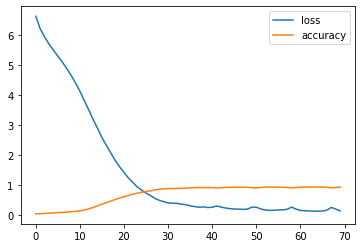

In [41]:
losses1=pd.DataFrame(model1.history.history)
losses1.plot()

## Load Model 1

In [42]:
# Load the model and tokenizer
#model = load_model('next_words.h5')
#tokenizer = pickle.load(open('token.pkl', 'rb'))

## Predict Words

In [43]:
def Predict_Words(model, tokenizer, text,n_word):
    result=text
    for _ in range(n_word):
        sequence = tokenizer.texts_to_sequences([text])
        sequence = np.array(sequence)
        preds = np.argmax(model.predict(sequence))
        predicted_word = ""

        for key, value in tokenizer.word_index.items():
            if value == preds:
                predicted_word = key
                break
        result+=" "+predicted_word
        text=str(text)
        text = text.split(" ")
        text = text[-3:]
        text+=" "+predicted_word

    return result

In [51]:
#good
print(Predict_Words(model1, tokenizer, "What surprised you",1))
print(Predict_Words(model1, tokenizer, "have been three",5))
print(Predict_Words(model1, tokenizer, "I get a chance",2))
print(Predict_Words(model1, tokenizer, "last case of",5))
print(Predict_Words(model1, tokenizer, "I'm really grateful",6))
print(Predict_Words(model1, tokenizer, "human creativity in",2))

What surprised you have
have been three themes i think you n
I get a chance we to
last case of the on in or of
I'm really grateful to world you n in we
human creativity in it this


In [45]:
#not so good
print(Predict_Words(model1, tokenizer, "good morning my",2))
print( Predict_Words(model1, tokenizer, "I would have never",3))
print(Predict_Words(model1, tokenizer, "I have an interest",2))
print(Predict_Words(model1, tokenizer, "If you work",4))

good morning my zoning i'm
I would have never end they and
I have an interest and the
If you work in what working have


In [46]:
print( Predict_Words(model1, tokenizer, "I would have never",22))

I would have never end they and it to and it to and it to and it to and it to and it to and it


# Model 2

another model take 3 words as input

In [53]:
model2 = Sequential()
model2.add(Embedding(vocab_size, 10, input_length=3))
model2.add(LSTM(1000, return_sequences=True))
model2.add(Dropout(0.2))
model2.add(LSTM(1000))
model2.add(Dropout(0.2))
model2.add(Dense(1000, activation="relu"))
model2.add(Dense(vocab_size, activation="softmax"))

In [54]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 3, 10)             30610     
                                                                 
 lstm_2 (LSTM)               (None, 3, 1000)           4044000   
                                                                 
 dropout (Dropout)           (None, 3, 1000)           0         
                                                                 
 lstm_3 (LSTM)               (None, 1000)              8004000   
                                                                 
 dropout_1 (Dropout)         (None, 1000)              0         
                                                                 
 dense_2 (Dense)             (None, 1000)              1001000   
                                                                 
 dense_3 (Dense)             (None, 3061)             

In [55]:
#checkpoint = ModelCheckpoint("next_words_3.h5", monitor='loss', verbose=1, save_best_only=True)
model2.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.001),metrics=["accuracy"])
model2.fit(X_train, y_train, epochs=70, batch_size=64,validation_data=[X_test,y_test])

Epoch 1/70
225/225 [==============================] - 47s 196ms/step - loss: 6.7036 - accuracy: 0.0448 - val_loss: 6.5520 - val_accuracy: 0.0524
Epoch 2/70
225/225 [==============================] - 41s 180ms/step - loss: 6.2580 - accuracy: 0.0498 - val_loss: 6.5362 - val_accuracy: 0.0602
Epoch 3/70
225/225 [==============================] - 41s 181ms/step - loss: 6.0251 - accuracy: 0.0594 - val_loss: 6.5695 - val_accuracy: 0.0627
Epoch 4/70
225/225 [==============================] - 41s 184ms/step - loss: 5.8231 - accuracy: 0.0626 - val_loss: 6.6896 - val_accuracy: 0.0650
Epoch 5/70
225/225 [==============================] - 42s 185ms/step - loss: 5.6399 - accuracy: 0.0698 - val_loss: 6.8060 - val_accuracy: 0.0719
Epoch 6/70
225/225 [==============================] - 43s 189ms/step - loss: 5.4394 - accuracy: 0.0807 - val_loss: 6.9901 - val_accuracy: 0.0733
Epoch 7/70
225/225 [==============================] - 44s 197ms/step - loss: 5.2383 - accuracy: 0.0890 - val_loss: 7.2422 - val_ac

In [56]:
losses2=pd.DataFrame(model2.history.history)
losses2.head()

,loss,accuracy,val_loss,val_accuracy
0,6.703557,0.044833,6.552019,0.052426
1,6.257991,0.049784,6.536197,0.060234
2,6.025069,0.059406,6.569488,0.062744
3,5.823123,0.062613,6.689568,0.064975
4,5.639948,0.069795,6.806018,0.071946


<AxesSubplot:>

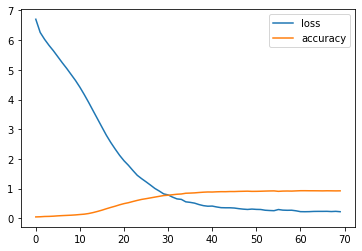

In [57]:
losses2[["loss","accuracy"]].plot()

<AxesSubplot:>

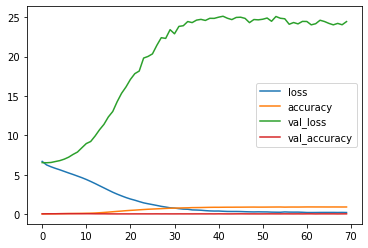

In [58]:
losses2.plot()

## load model

In [59]:
# Load the model and tokenizer
#loaded_model = load_model('next_words_3.h5')
#tokenizer = pickle.load(open('token.pkl', 'rb'))

## prediction

In [65]:
#good
print(Predict_Words(model2, tokenizer, "What surprised you",2))
print(Predict_Words(model2, tokenizer, "have been three",1))
print(Predict_Words(model2, tokenizer, "last case of",3))
print(Predict_Words(model2, tokenizer, "I'm really grateful",4))
print(Predict_Words(model2, tokenizer, "human creativity in",2))
print(Predict_Words(model2, tokenizer, "good morning my",3))
print( Predict_Words(model2, tokenizer, "I would have never",2))

What surprised you have we
have been three themes
last case of the so be
I'm really grateful i don't the place
human creativity in that i
good morning my very think it
I would have never must through


In [63]:
#not so good
print(Predict_Words(model2, tokenizer, "I get a chance",5))
print(Predict_Words(model2, tokenizer, "I have an interest",2))
print(Predict_Words(model2, tokenizer, "If you work",5))

I get a chance we to place world to
I have an interest that degrees
If you work in which wrote 4 you


In [64]:
print( Predict_Words(model2, tokenizer, "I would have never",22))

I would have never must through the place world to place world to place world to place world to place world to place world to place
